In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import pandas as pd
import datetime
import time


import glob
import os

#
import imageio

# pyplot
from plotly.offline import plot, iplot
import plotly.graph_objs as go

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

In [3]:
# -*- coding: utf-8 -*-
"""
:Author: Chankyu Choi
:Date: 2019. 10. 29
"""
from tqdm import tqdm
import warnings
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from columns import *

from bs_formula import *
from get_option_maturity import meetup_day
#from volatility.DNN_model_vol import DNN_vol
#from volatility.LSTM_model_vol import GRU_vol

warnings.filterwarnings(action='ignore')
# read data
# futures
KS200_futures = pd.read_csv('data/KOSPI 200 Futures Historical Data(2014.01.01 ~ 2019.06.30)_.csv')[
    ['TRADE_DATE', 'Price']]
KS200_futures.rename(columns={'TRADE_DATE': TRADE_DATE, 'Price': KS200_F}, inplace=True)
KS200_futures.sort_values(TRADE_DATE, inplace=True)
KS200_futures[TRADE_DATE] = pd.to_datetime(KS200_futures[TRADE_DATE], format='%Y-%m-%d')
KS200_futures[KS200_F_CHG] = KS200_futures[KS200_F] - KS200_futures[KS200_F].shift(1)
KS200_futures[KS200_F_RET] = KS200_futures[KS200_F_CHG] / KS200_futures[KS200_F].shift(1)

# interest rate
interest = pd.read_csv('data/South Korea 1-Year Bond Yield Historical Data_.csv')[['TRADE_DATE', 'Price']]
interest.rename(columns={'TRADE_DATE': TRADE_DATE, 'Price': KO_ONE_YEAR_TREASURY_RATE}, inplace=True)
interest[TRADE_DATE] = pd.to_datetime(interest[TRADE_DATE], format='%Y-%m-%d')
interest.sort_values(TRADE_DATE, inplace=True)
interest[KO_ONE_YEAR_TREASURY_RATE] *= 0.01
interest.set_index(TRADE_DATE, inplace=True)
interest = interest.resample('D').last()
interest.interpolate(method='linear', inplace=True)
interest.reset_index(inplace=True)

# dividend rate
dividend = pd.read_csv('data/코스피200_배당수익률_20191126223044_.csv')
dividend[TRADE_DATE] = pd.to_datetime(dividend[TRADE_DATE], format='%Y. %m')
dividend[KS200_DIV] *= 0.01
dividend.set_index(TRADE_DATE, inplace=True)
dividend = dividend.resample('D').last()
dividend.interpolate(method='linear', inplace=True)
dividend.reset_index(inplace=True)

# option data
""" column names
- TRADE_DATE : 일자
- BASE_ASSET_CD : 기초자산코드
- VOL_CD : 변동성 종류(51:Implied, 52:Local)
- EXPMM : 만기월
- MONEYNESS : 가격도
- VOL : 변동성
"""
years = ['2014', '2015', '2016', '2017', '2018_2019']
# local vol
local_vol = pd.DataFrame()
for year in years:
    local_vol = pd.concat([local_vol, pd.read_excel('data/4740_Local_{}.xlsm'.format(year))], axis=0)
local_vol.rename(columns={'TRADE_DATE': TRADE_DATE, 'MONEYNESS': MONEYNESS, 'VOL': LOCAL_VOL}, inplace=True)
local_vol[TRADE_DATE] = pd.to_datetime(local_vol[TRADE_DATE], format='%Y%m%d')
local_vol[LOCAL_VOL] *= 0.01
del local_vol['VOL_CD']
del local_vol['BASE_ASSET_CD']
# implied vol
imp_vol = pd.DataFrame()
for year in years:
    imp_vol = pd.concat([imp_vol, pd.read_excel('data/4740_Implied_{}.xlsm'.format(year))], axis=0)
imp_vol.rename(columns={'TRADE_DATE': TRADE_DATE, 'MONEYNESS': MONEYNESS, 'VOL': IMPLIED_VOL}, inplace=True)
imp_vol[TRADE_DATE] = pd.to_datetime(imp_vol[TRADE_DATE], format='%Y%m%d')
imp_vol[IMPLIED_VOL] *= 0.01
del imp_vol['VOL_CD']
del imp_vol['BASE_ASSET_CD']
imp_vol = pd.merge(imp_vol, interest, how='left', on=[TRADE_DATE])
imp_vol = pd.merge(imp_vol, dividend, how='left', on=[TRADE_DATE])
imp_vol = pd.merge(imp_vol.set_index([TRADE_DATE, 'EXPMM', MONEYNESS]),
                   local_vol.set_index([TRADE_DATE, 'EXPMM', MONEYNESS]),
                   how='left', left_index=True, right_index=True).reset_index()

# volatility of volatility
vkospi = pd.read_csv('data/VKOSPI(2013.08.06~2019.11.01_).csv')
vkospi.rename(columns={'TRADE_DATE': TRADE_DATE, 'VKOSPI': VKOSPI}, inplace=True)  # 몇 개월로 해야하지?
vkospi[TRADE_DATE] = pd.to_datetime(vkospi[TRADE_DATE], format='%Y-%m-%d')
vkospi.sort_values(TRADE_DATE, inplace=True)

# setting data
total_data = pd.merge(imp_vol, vkospi, how='left', on=[TRADE_DATE])
total_data = pd.merge(total_data, KS200_futures, how='left', on=[TRADE_DATE])
total_data.sort_values(['EXPMM', MONEYNESS], inplace=True)
total_data.reset_index(drop=True, inplace=True)
total_data['imp_vol_chg'] = total_data.groupby(['EXPMM', MONEYNESS]).apply(
    lambda x: (x[IMPLIED_VOL] - x[IMPLIED_VOL].shift(1))).reset_index(drop=True)
total_data[MAT] = total_data.apply(lambda x: x[TRADE_DATE] + relativedelta(months=x['EXPMM']), axis=1)
total_data[MAT] = total_data.apply(lambda x: meetup_day(x[MAT].year, x[MAT].month, "Thursday", "2nd"), axis=1)
total_data[MAT] = pd.to_datetime(total_data[MAT], format='%Y-%m-%d')
total_data[TOW] = total_data.apply(lambda x: np.busday_count(x[TRADE_DATE].date(), x[MAT].date()) / 240, axis=1)
total_data.dropna(subset=[VKOSPI, KS200_F], inplace=True)

'\n:Author: Chankyu Choi\n:Date: 2019. 10. 29\n'

' column names\n- TRADE_DATE : 일자\n- BASE_ASSET_CD : 기초자산코드\n- VOL_CD : 변동성 종류(51:Implied, 52:Local)\n- EXPMM : 만기월\n- MONEYNESS : 가격도\n- VOL : 변동성\n'

## 0) data processing

In [4]:
# remove 2019-06 data
total_data = total_data.iloc[:,:-1]

#transform data into time series
total_data2 = total_data.copy()
total_data = total_data.set_index("trade_date")

In [28]:
# set interval 
start_date = '2018-01-01' 
end_date = '2018-02-10'
data = total_data[start_date:end_date]

# create data for purpose
kospi = data[['kospi200_futures']]
impvol = data[['EXPMM', 'moneyness', 'implied_volatility']]
impvol_chg = data[['EXPMM', 'moneyness', 'imp_vol_chg']]

## 1) 단일 3D plot by matplotlib

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline

In [17]:
impvol_chg.loc[:, 'imp_vol_chg'].min()

-0.04687299999999994

(0, 1.2)

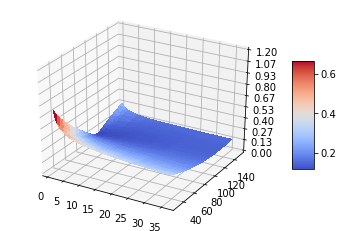

In [18]:
fig = plt.figure()
ax = fig.gca(projection='3d')

date = datetime.strptime('2018-01-03', "%Y-%m-%d")

# Make data.
X = impvol.loc[date, 'EXPMM']
Y = impvol.loc[date, 'moneyness']
Z = impvol.loc[date, 'implied_volatility']

# Plot the surface.
#X, Y = np.meshgrid(X, Y), Z=X*2+Y*2과같이 Z가 X, Y식으로 표현될 경우 plot_surface
surf = ax.plot_trisurf(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


# Customize the z axis.
ax.set_zlim(0, 1.2)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5 ,ax=ax)

#fig.clf()
#plt.close()
#ax.cla()


In [19]:
fig.clf()
plt.close()
ax.cla()

# 2) 3D surface_plot

### 2-1) create folder,  managing path

In [23]:
# fuction : createFolder
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
        
# Creates a folder in the current directory called data
createFolder('C:/Users/ljh8006/data/0')

In [24]:
path = r"C:/Users/ljh8006/data"
createFolder(path+'/image0')

In [25]:
len(os.listdir(path))

19

### 2-2)  distinguish bull/bear market  (criteria : kospi_200_futures)

In [137]:
# 코스피 데이터 일별 평균량... 일별 코스피는 동일하기때문에 일종의 유니크개념
ko = kospi.resample('D').mean().dropna().reset_index()

In [129]:
shift_m1 = ko.iloc[1:,]
shift_m1 = shift_m1.set_index(np.arange(shift_m1.shape[0]))

In [130]:
# t+1시점에서 t시점의 값을 뺀값
df = shift_m1-ko[:-1]
df = df[['kospi200_futures']]

In [131]:
df = pd.DataFrame(np.array([[0]]), columns=['kospi200_futures']).append(df, ignore_index=True)
#df.append({'kospi200_futures' : 0} , ignore_index=True)
df = df.rename(columns = {'kospi200_futures' :'updown'})

In [132]:
kospi_u = pd.concat([ko,df], axis=1)
kospi_u = kospi_u.set_index("trade_date")

In [133]:
kospi_u[kospi_u['updown'] >= 0]['kospi200_futures']

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
2018-01-19    330.1
2018-01-23    331.8
2018-01-24    332.1
2018-01-25    334.8
2018-01-26    336.4
2018-01-29    339.0
2018-01-31    334.9
2018-02-08    313.0
Name: kospi200_futures, dtype: float64

### 2-2) save suface_plot in folder

In [135]:
#kospi_u = kospi.resample('D').mean().dropna()
#kospi_mean = kospi_u.mean()[0]
dates = list(kospi_u.index)

%matplotlib inline
for date in tqdm(dates):
    #fig, (ax1, ax2) = plt.subplots(2,1, figsize = (25,19))
    #plt.subplot(211)
    #fig = plt.figure()
    #ax1 = fig.add_subplot(2, 1, 1)
    #ax2 = fig.add_subplot(2, 1, 2)
    fig = plt.figure(figsize=(25,25))
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0,0], projection='3d')
    ax2 = fig.add_subplot(gs[0,1], projection='3d')
    ax3 = fig.add_subplot(gs[1,0:])
    ax3.plot(kospi_u[['kospi200_futures']], color='gray')
    
    # Make data.
    X = impvol.loc[date, 'EXPMM']
    Y = impvol.loc[date, 'moneyness']
    Z1 = impvol.loc[date, 'implied_volatility']
    Z2 = impvol_chg.loc[date, 'imp_vol_chg']
    Z3 = kospi.loc[date, 'kospi200_futures']
    

    # Plot the surface.
    #X, Y = np.meshgrid(X, Y), Z=X*2+Y*2과같이 Z가 X, Y식으로 표현될 경우 plot_surface
    surf = ax1.plot_trisurf(X, Y, Z1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    
    
    surf2 = ax2.plot_trisurf(X, Y, Z2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    
    
    kospi_date = kospi_u[:date]
    kospi_date[kospi_date['updown'] >= 0]['kospi200_futures']
    
    bull = kospi_date[kospi_date['updown'] >= 0][['kospi200_futures']]
    bear = kospi_date[kospi_date['updown'] < 0][['kospi200_futures']]
    ax3.plot(kospi_u[['kospi200_futures']][:date], linewidth=3)
    ax3.plot(bull,'ro')  
    ax3.plot(bear,'bo')
    ax3.text(date, kospi_u[['kospi200_futures']].loc[date][0],np.round(kospi_u[['kospi200_futures']].loc[date][0],1), fontsize=20)

    ax3.axvline(date, color='black', alpha=0.5, linewidth=5)

    
    

    # Customize the z axis.
    #ax1.set_zlim(0, 1.2)
    ax1.zaxis.set_major_locator(LinearLocator(10))
    ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    
    #ax2.set_zlim(-0.05, 0.2)
    ax2.zaxis.set_major_locator(LinearLocator(10))
    ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    
    
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5, ax=ax1)    
    fig.colorbar(surf, shrink=0.5, aspect=5, ax=ax2) 
    
    
    # lablel
    ax1.set_title('implied_vol_change', fontsize=25)
    ax1.set_xlabel('expmm', fontsize=20)
    ax1.set_ylabel('monyness', fontsize=20)
    
    ax2.set_title('implied_vol', fontsize=25)
    ax2.set_xlabel('expmm', fontsize=20)
    ax2.set_ylabel('monyness', fontsize=20)
    
    
    ax3.set_title('kospi200_futures', fontsize=25)
    ax3.set_ylabel('',fontsize=20)
    ax3.tick_params(axis='x', which='major', labelsize=15)
    
    #
    folder_name = 'C:/Users/ljh8006/data/image0'

    str_date = datetime.strftime(date, format='%Y-%m-%d')
    plt.savefig(folder_name+'/{}.png'.format(str_date), bbox_inches='tight')
    
    #memory release
    plt.close()
    fig.clf()
    ax1.cla()
    ax2.cla()
    ax3.cla()



  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

trade_date
2018-01-02    327.0
Name: kospi200_futures, dtype: float64

Text(2018-01-02 00:00:00, 327.0, '327.0')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



  3%|██▊                                                                                | 1/29 [00:00<00:24,  1.16it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
Name: kospi200_futures, dtype: float64

Text(2018-01-03 00:00:00, 328.1999999999986, '328.2')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



  7%|█████▋                                                                             | 2/29 [00:01<00:23,  1.16it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
Name: kospi200_futures, dtype: float64

Text(2018-01-04 00:00:00, 325.5, '325.5')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 10%|████████▌                                                                          | 3/29 [00:02<00:22,  1.14it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
Name: kospi200_futures, dtype: float64

Text(2018-01-05 00:00:00, 329.4000000000002, '329.4')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 14%|███████████▍                                                                       | 4/29 [00:03<00:22,  1.09it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
Name: kospi200_futures, dtype: float64

Text(2018-01-08 00:00:00, 331.80000000000143, '331.8')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 17%|██████████████▎                                                                    | 5/29 [00:04<00:21,  1.11it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
Name: kospi200_futures, dtype: float64

Text(2018-01-09 00:00:00, 330.9000000000002, '330.9')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 21%|█████████████████▏                                                                 | 6/29 [00:05<00:20,  1.11it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
Name: kospi200_futures, dtype: float64

Text(2018-01-10 00:00:00, 328.40000000000026, '328.4')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 24%|████████████████████                                                               | 7/29 [00:06<00:19,  1.12it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
Name: kospi200_futures, dtype: float64

Text(2018-01-11 00:00:00, 327.0, '327.0')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 28%|██████████████████████▉                                                            | 8/29 [00:07<00:19,  1.08it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
Name: kospi200_futures, dtype: float64

Text(2018-01-12 00:00:00, 327.40000000000026, '327.4')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 31%|█████████████████████████▊                                                         | 9/29 [00:08<00:18,  1.08it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
Name: kospi200_futures, dtype: float64

Text(2018-01-15 00:00:00, 327.8000000000014, '327.8')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 34%|████████████████████████████▎                                                     | 10/29 [00:09<00:17,  1.09it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
Name: kospi200_futures, dtype: float64

Text(2018-01-16 00:00:00, 331.0, '331.0')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 38%|███████████████████████████████                                                   | 11/29 [00:09<00:16,  1.11it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
Name: kospi200_futures, dtype: float64

Text(2018-01-17 00:00:00, 329.6999999999986, '329.7')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 41%|█████████████████████████████████▉                                                | 12/29 [00:10<00:15,  1.08it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
Name: kospi200_futures, dtype: float64

Text(2018-01-18 00:00:00, 329.9000000000002, '329.9')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 45%|████████████████████████████████████▊                                             | 13/29 [00:11<00:14,  1.10it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
2018-01-19    330.1
Name: kospi200_futures, dtype: float64

Text(2018-01-19 00:00:00, 330.0999999999998, '330.1')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 48%|███████████████████████████████████████▌                                          | 14/29 [00:12<00:13,  1.11it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
2018-01-19    330.1
Name: kospi200_futures, dtype: float64

Text(2018-01-22 00:00:00, 326.8000000000014, '326.8')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 52%|██████████████████████████████████████████▍                                       | 15/29 [00:13<00:12,  1.08it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
2018-01-19    330.1
2018-01-23    331.8
Name: kospi200_futures, dtype: float64

Text(2018-01-23 00:00:00, 331.80000000000143, '331.8')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 55%|█████████████████████████████████████████████▏                                    | 16/29 [00:14<00:12,  1.06it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
2018-01-19    330.1
2018-01-23    331.8
2018-01-24    332.1
Name: kospi200_futures, dtype: float64

Text(2018-01-24 00:00:00, 332.0999999999998, '332.1')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 59%|████████████████████████████████████████████████                                  | 17/29 [00:15<00:11,  1.08it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
2018-01-19    330.1
2018-01-23    331.8
2018-01-24    332.1
2018-01-25    334.8
Name: kospi200_futures, dtype: float64

Text(2018-01-25 00:00:00, 334.80000000000143, '334.8')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 62%|██████████████████████████████████████████████████▉                               | 18/29 [00:16<00:10,  1.09it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
2018-01-19    330.1
2018-01-23    331.8
2018-01-24    332.1
2018-01-25    334.8
2018-01-26    336.4
Name: kospi200_futures, dtype: float64

Text(2018-01-26 00:00:00, 336.4000000000001, '336.4')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 66%|█████████████████████████████████████████████████████▋                            | 19/29 [00:17<00:09,  1.10it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
2018-01-19    330.1
2018-01-23    331.8
2018-01-24    332.1
2018-01-25    334.8
2018-01-26    336.4
2018-01-29    339.0
Name: kospi200_futures, dtype: float64

Text(2018-01-29 00:00:00, 339.0, '339.0')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 69%|████████████████████████████████████████████████████████▌                         | 20/29 [00:18<00:08,  1.08it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
2018-01-19    330.1
2018-01-23    331.8
2018-01-24    332.1
2018-01-25    334.8
2018-01-26    336.4
2018-01-29    339.0
Name: kospi200_futures, dtype: float64

Text(2018-01-30 00:00:00, 334.40000000000015, '334.4')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 72%|███████████████████████████████████████████████████████████▍                      | 21/29 [00:19<00:07,  1.07it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
2018-01-19    330.1
2018-01-23    331.8
2018-01-24    332.1
2018-01-25    334.8
2018-01-26    336.4
2018-01-29    339.0
2018-01-31    334.9
Name: kospi200_futures, dtype: float64

Text(2018-01-31 00:00:00, 334.90000000000015, '334.9')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 76%|██████████████████████████████████████████████████████████████▏                   | 22/29 [00:20<00:06,  1.09it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
2018-01-19    330.1
2018-01-23    331.8
2018-01-24    332.1
2018-01-25    334.8
2018-01-26    336.4
2018-01-29    339.0
2018-01-31    334.9
Name: kospi200_futures, dtype: float64

Text(2018-02-01 00:00:00, 334.09999999999985, '334.1')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 79%|█████████████████████████████████████████████████████████████████                 | 23/29 [00:20<00:05,  1.11it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
2018-01-19    330.1
2018-01-23    331.8
2018-01-24    332.1
2018-01-25    334.8
2018-01-26    336.4
2018-01-29    339.0
2018-01-31    334.9
Name: kospi200_futures, dtype: float64

Text(2018-02-02 00:00:00, 327.90000000000026, '327.9')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 83%|███████████████████████████████████████████████████████████████████▊              | 24/29 [00:21<00:04,  1.08it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
2018-01-19    330.1
2018-01-23    331.8
2018-01-24    332.1
2018-01-25    334.8
2018-01-26    336.4
2018-01-29    339.0
2018-01-31    334.9
Name: kospi200_futures, dtype: float64

Text(2018-02-05 00:00:00, 323.5, '323.5')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 86%|██████████████████████████████████████████████████████████████████████▋           | 25/29 [00:22<00:03,  1.10it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
2018-01-19    330.1
2018-01-23    331.8
2018-01-24    332.1
2018-01-25    334.8
2018-01-26    336.4
2018-01-29    339.0
2018-01-31    334.9
Name: kospi200_futures, dtype: float64

Text(2018-02-06 00:00:00, 318.09999999999957, '318.1')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 90%|█████████████████████████████████████████████████████████████████████████▌        | 26/29 [00:23<00:02,  1.11it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
2018-01-19    330.1
2018-01-23    331.8
2018-01-24    332.1
2018-01-25    334.8
2018-01-26    336.4
2018-01-29    339.0
2018-01-31    334.9
Name: kospi200_futures, dtype: float64

Text(2018-02-07 00:00:00, 310.0, '310.0')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 93%|████████████████████████████████████████████████████████████████████████████▎     | 27/29 [00:24<00:01,  1.12it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
2018-01-19    330.1
2018-01-23    331.8
2018-01-24    332.1
2018-01-25    334.8
2018-01-26    336.4
2018-01-29    339.0
2018-01-31    334.9
2018-02-08    313.0
Name: kospi200_futures, dtype: float64

Text(2018-02-08 00:00:00, 313.0, '313.0')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



 97%|███████████████████████████████████████████████████████████████████████████████▏  | 28/29 [00:25<00:00,  1.08it/s]

trade_date
2018-01-02    327.0
2018-01-03    328.2
2018-01-05    329.4
2018-01-08    331.8
2018-01-12    327.4
2018-01-15    327.8
2018-01-16    331.0
2018-01-18    329.9
2018-01-19    330.1
2018-01-23    331.8
2018-01-24    332.1
2018-01-25    334.8
2018-01-26    336.4
2018-01-29    339.0
2018-01-31    334.9
2018-02-08    313.0
Name: kospi200_futures, dtype: float64

Text(2018-02-09 00:00:00, 304.4000000000007, '304.4')

Text(0.5, 0.92, 'implied_vol_change')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 0.92, 'implied_vol')

Text(0.5, 0, 'expmm')

Text(0.5, 0, 'monyness')

Text(0.5, 1.0, 'kospi200_futures')

Text(0, 0.5, '')



100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:26<00:00,  1.10it/s]


#outputFile (str) – 저장될 파일명
#fourcc – Codec정보. cv2.VideoWriter_fourcc()
#frame (float) – 초당 저장될 frame
#size (list) – 저장될 사이즈(ex; 640, 480)

In [34]:
import cv2

In [35]:
filenames = [folder_name + '/' + file_name for file_name in os.listdir(folder_name)]
filenames[-1:]

['C:/Users/ljh8006/data/image0/2018-02-09.png']

In [36]:
for i, filename in enumerate(glob.glob(folder_name+'/*.png')):
    if i <5 :
        print(filename)
    else :
        break

C:/Users/ljh8006/data/image0\2018-01-02.png
C:/Users/ljh8006/data/image0\2018-01-03.png
C:/Users/ljh8006/data/image0\2018-01-04.png
C:/Users/ljh8006/data/image0\2018-01-05.png
C:/Users/ljh8006/data/image0\2018-01-08.png


## 4) create video with opencv

In [136]:
import cv2
import numpy as np
import glob
 
img_array = []
for filename in glob.glob(folder_name+'/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 3, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

cv2.destroyAllWindows() 